<a href="https://colab.research.google.com/github/bjrodarmel/MGMT467_Team12/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Phase 1: This will load in a simulated kaggle weather dataset that we will save and upload to GCS

In [1]:
import requests
import pandas as pd
from google.cloud import bigquery
from google.cloud import storage
from google.colab import auth

# --- 1. AUTHENTICATION ---
# This opens a pop-up to log in with your Google Cloud account
auth.authenticate_user()
print("Authenticated successfully.")

# --- CONFIGURATION ---
# We use your existing project ID
project_id = 'mgmt-467'
bucket_name = 'weather-bucket-mgmt-467' # Must be unique globally
dataset_id = 'weather_data'
table_id = 'weather_history'

# --- STEP 2: EXTRACT (Simulate Kaggle/Batch Source) ---
print("Fetching raw weather data from Open-Meteo...")
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": 40.71, # New York Coordinates
    "longitude": -74.01,
    "start_date": "2024-01-01",
    "end_date": "2025-12-01",
    "hourly": "temperature_2m",
    "timezone": "UTC"
}
resp = requests.get(url, params=params)
data = resp.json()

# Convert JSON to Pandas DataFrame
df = pd.DataFrame({
    'timestamp': data['hourly']['time'],
    'temperature': data['hourly']['temperature_2m']
})

# --- REQUIREMENT: TRANSFORMATION LOGIC EXPLANATION ---
# Logic: The API returns 'YYYY-MM-DDTHH:MM' (ISO 8601 without seconds).
# BigQuery's standard TIMESTAMP format prefers 'YYYY-MM-DD HH:MM:SS'.
# We append ':00' to seconds to standardize the format for the database.
df['timestamp'] = df['timestamp'].astype(str) + ":00"

# --- REQUIREMENT: DATA QUALITY CHECK ---
# Logic: We must ensure no temperature readings are missing before analysis.
# If any are NULL, we fill them with 0 to prevent model crashes (Imputation).
if df['temperature'].isnull().sum() > 0:
    print(f"⚠️ WARNING: Found {df['temperature'].isnull().sum()} null values. Filling with 0.")
    df['temperature'] = df['temperature'].fillna(0)
else:
    print("✅ Quality Check Passed: No null temperatures found.")

# --- STEP 3: LOAD RAW DATA TO GCS (Requirement: Store Raw Data) ---
csv_filename = 'nyc_weather_history.csv'
# Save locally first
df.to_csv(csv_filename, index=False)

# Upload to Google Cloud Storage
storage_client = storage.Client(project=project_id)
try:
    # Try creating a new bucket
    bucket = storage_client.create_bucket(bucket_name, location='US')
    print(f"Created new bucket: {bucket_name}")
except:
    # If it exists, grab the existing one
    bucket = storage_client.get_bucket(bucket_name)

blob = bucket.blob(csv_filename)
blob.upload_from_filename(csv_filename)
print(f"Uploaded raw data to: gs://{bucket_name}/{csv_filename}")

# --- STEP 4: LOAD TO BIGQUERY (Requirement: Curated Tables + Schema) ---
bq_client = bigquery.Client(project=project_id)
dataset_ref = bq_client.create_dataset(dataset_id, exists_ok=True)

# Requirement: Document Schema Explicitly
schema = [
    bigquery.SchemaField("timestamp", "TIMESTAMP", mode="REQUIRED", description="Observation time (UTC)"),
    bigquery.SchemaField("temperature", "FLOAT", mode="NULLABLE", description="Air temperature in Celsius"),
]

job_config = bigquery.LoadJobConfig(
    source_format=bigquery.SourceFormat.CSV,
    skip_leading_rows=1, # Skip the header row of the CSV
    schema=schema,       # Use our explicit schema
    write_disposition="WRITE_TRUNCATE", # Overwrite table if it exists

    # Requirement: Partitioning
    # We partition by DAY. This optimizes query costs by grouping data by date.
    time_partitioning=bigquery.TimePartitioning(
        type_=bigquery.TimePartitioningType.DAY,
        field="timestamp"
    )
)

uri = f"gs://{bucket_name}/{csv_filename}"
load_job = bq_client.load_table_from_uri(
    uri,
    f"{dataset_id}.{table_id}",
    job_config=job_config
)

print("Starting BigQuery load job...")
load_job.result()  # Waits for the job to complete

# Verify the result
destination_table = bq_client.get_table(f"{dataset_id}.{table_id}")
print(f"Success! Loaded {destination_table.num_rows} rows into table: {dataset_id}.{table_id}")
print(f"Partitioning: {destination_table.time_partitioning.type_}")

Authenticated successfully.
Fetching raw weather data from Open-Meteo...
✅ Quality Check Passed: No null temperatures found.
Uploaded raw data to: gs://weather-bucket-mgmt-467/nyc_weather_history.csv
Starting BigQuery load job...
Success! Loaded 16824 rows into table: weather_data.weather_history
Partitioning: DAY


The next step was ingesting the streaming of live weather data through Pub/Sub

This will test to make sure the data was ingested correctly

In [4]:
from google.cloud import bigquery
import pandas as pd

# --- CONFIGURATION ---
project_id = 'mgmt-467'
dataset_id = 'weather_data'
table_id = 'weather_history'

client = bigquery.Client(project=project_id)

# 1. Query the Table
print(f"Querying {dataset_id}.{table_id}...")

query = f"""
    SELECT *
    FROM `{project_id}.{dataset_id}.{table_id}`
    ORDER BY timestamp DESC
    LIMIT 10
"""

# 2. Convert to DataFrame and Display
try:
    df = client.query(query).to_dataframe()

    if not df.empty:
        print("\n✅ SUCCESS: Data found!")
        print(f"Displaying top {len(df)} most recent rows:")
        display(df) # Prints a nice interactive table in Colab

        # Optional: Print schema confirmation
        print("\nTable Schema:")
        print(df.dtypes)
    else:
        print("⚠️ WARNING: Table exists but is empty.")

except Exception as e:
    print(f"❌ ERROR: Could not query table. Details: {e}")

Querying weather_data.weather_history...

✅ SUCCESS: Data found!
Displaying top 10 most recent rows:


,timestamp,temperature
0,2025-12-01 23:00:00+00:00,2.2
1,2025-12-01 22:00:00+00:00,3.0
2,2025-12-01 21:00:00+00:00,4.5
3,2025-12-01 20:00:00+00:00,5.5
4,2025-12-01 19:00:00+00:00,6.0
5,2025-12-01 18:00:00+00:00,5.8
6,2025-12-01 17:00:00+00:00,4.9
7,2025-12-01 16:00:00+00:00,4.6
8,2025-12-01 15:00:00+00:00,4.0
9,2025-12-01 14:00:00+00:00,3.7



Table Schema:
timestamp      datetime64[us, UTC]
temperature                float64
dtype: object


Now that everything has been streaming, we will now attempt to train the model

In [6]:
from google.cloud import bigquery
import pandas as pd

client = bigquery.Client(project='mgmt-467')

print("--- PART A: The Main Model (ARIMA for Dashboard) ---")

# 1. Train ARIMA Model (Same as before)
print("1. Training ARIMA Model...")
train_arima = """
CREATE OR REPLACE MODEL `mgmt-467.weather_data.weather_model_arima`
OPTIONS(
  model_type = 'ARIMA_PLUS',
  time_series_timestamp_col = 'timestamp_parsed',
  time_series_data_col = 'temperature',
  data_frequency = 'AUTO_FREQUENCY'
) AS
SELECT
  timestamp as timestamp_parsed, -- Corrected: timestamp is already a TIMESTAMP type
  temperature
FROM
  `mgmt-467.weather_data.weather_history`
"""
client.query(train_arima).result()

# 2. ML.EVALUATE (Requirement: Evaluate the model)
print("2. Evaluating ARIMA Model...")
eval_arima = """
SELECT *
FROM ML.EVALUATE(MODEL `mgmt-467.weather_data.weather_model_arima`)
"""
df_eval = client.query(eval_arima).to_dataframe()
print("   ► ARIMA Metrics (AIC, Variance, etc):")
display(df_eval)

# 3. Create the Anomaly View (For Dashboard)
print("3. Creating Dashboard View...")
view_sql = """
CREATE OR REPLACE VIEW `mgmt-467.weather_data.weather_anomalies_view` AS
SELECT
  timestamp_parsed,
  temperature,
  is_anomaly,
  lower_bound,
  upper_bound,
  anomaly_probability -- This serves as our "Threshold" metric
FROM
  ML.DETECT_ANOMALIES(
    MODEL `mgmt-467.weather_data.weather_model_arima`,
    STRUCT(0.8 AS anomaly_prob_threshold), -- Requirement: Threshold Discussion (We use 0.8)
    (
      SELECT timestamp as timestamp_parsed, temperature -- Corrected: timestamp from history is already TIMESTAMP
      FROM `mgmt-467.weather_data.weather_history`
      UNION ALL
      SELECT PARSE_TIMESTAMP('%Y-%m-%dT%H:%M:%S', timestamp) as timestamp_parsed, temperature -- Assuming streaming data timestamp is STRING
      FROM `mgmt-467.weather_data.weather_streaming`
    )
  )
"""
client.query(view_sql).result()


print("\n--- PART B: The Compliance Model (Regression for ML.EXPLAIN_PREDICT) ---")
# Strategy: We build a simple regression to predict temp based on the "Hour of Day"
# This allows us to use ML.EXPLAIN_PREDICT to satisfy the rubric.

# 4. Train Linear Regression Model
print("4. Training Linear Regression Model...")
train_reg = """
CREATE OR REPLACE MODEL `mgmt-467.weather_data.weather_model_regression`
OPTIONS(model_type='LINEAR_REG') AS
SELECT
  temperature as label,
  -- Feature: Extract Hour from timestamp (Batch Feature)
  EXTRACT(HOUR FROM timestamp) as hour_of_day -- Corrected: timestamp is already a TIMESTAMP type
FROM
  `mgmt-467.weather_data.weather_history`
"""
client.query(train_reg).result()

# 5. ML.EXPLAIN_PREDICT (Requirement: Explain Predict)
print("5. Running ML.EXPLAIN_PREDICT on Streaming Data...")
explain_sql = """
SELECT
  *
FROM
  ML.EXPLAIN_PREDICT(
    MODEL `mgmt-467.weather_data.weather_model_regression`,
    (
      -- We score the STREAMING data using the BATCH model
      SELECT
        temperature as label,
        EXTRACT(HOUR FROM PARSE_TIMESTAMP('%Y-%m-%dT%H:%M:%S', timestamp)) as hour_of_day, -- Assuming streaming data timestamp is STRING
        timestamp
      FROM `mgmt-467.weather_data.weather_streaming`
    )
  )
ORDER BY timestamp DESC
LIMIT 5
"""
df_explain = client.query(explain_sql).to_dataframe()
print("   ► Explain Predict Results (Top 5 features driving the prediction):")
display(df_explain)


--- PART A: The Main Model (ARIMA for Dashboard) ---
1. Training ARIMA Model...
2. Evaluating ARIMA Model...
   ► ARIMA Metrics (AIC, Variance, etc):


,non_seasonal_p,non_seasonal_d,non_seasonal_q,has_drift,log_likelihood,AIC,variance,seasonal_periods,has_holiday_effect,has_spikes_and_dips,has_step_changes
0,1,1,1,False,-9149.209443,18304.418886,0.173742,"[DAILY, WEEKLY]",False,False,True
1,1,1,1,True,-9149.134986,18306.269972,0.173741,"[DAILY, WEEKLY]",False,False,True
2,2,1,0,False,-9150.879462,18307.758924,0.173777,"[DAILY, WEEKLY]",False,False,True
3,2,1,0,True,-9150.803188,18309.606377,0.173775,"[DAILY, WEEKLY]",False,False,True
4,1,1,0,False,-9168.075508,18340.151015,0.174132,"[DAILY, WEEKLY]",False,False,True
5,1,1,0,True,-9167.992226,18341.984453,0.174131,"[DAILY, WEEKLY]",False,False,True
6,0,1,2,False,-9188.760260,18383.520519,0.174561,"[DAILY, WEEKLY]",False,False,True
7,0,1,2,True,-9188.668950,18385.337901,0.174559,"[DAILY, WEEKLY]",False,False,True
8,0,1,1,False,-9334.002428,18672.004856,0.177602,"[DAILY, WEEKLY]",False,False,True
9,0,1,1,True,-9333.890674,18673.781348,0.177600,"[DAILY, WEEKLY]",False,False,True


3. Creating Dashboard View...

--- PART B: The Compliance Model (Regression for ML.EXPLAIN_PREDICT) ---
4. Training Linear Regression Model...
5. Running ML.EXPLAIN_PREDICT on Streaming Data...
   ► Explain Predict Results (Top 5 features driving the prediction):


,predicted_label,top_feature_attributions,baseline_prediction_value,prediction_value,approximation_error,label,hour_of_day,timestamp


Now that the model has been trained, it is time to build the dashboard.

Prompt Design and DIVE

Section: Prompt Engineering & DIVE Journal

Summary: This project utilized a "Persona-Based" and "Chain-of-Thought" prompting strategy. The AI was assigned the persona of a Senior Cloud Architect and instructed to break down the pipeline into sequential execution phases (Batch, Streaming, Analytics, Visualization). Below are the DIVE journal entries documenting the evolution of the pipeline.

Entry 1: Schema Incompatibility & Timestamp Logic

D - Define (The Goal): I needed to ingest historical weather data from the Open-Meteo API (Batch) and load it into BigQuery to train the ARIMA model.

Prompt Strategy: I asked the AI to "Write a Python script to fetch the last year of hourly temperature data and load it to BigQuery."

I - Iterate (The Challenge): The initial load failed or created a suboptimal schema because the API returned timestamps in an ISO format ("2024-01-01T12:00"), which lacks the seconds precision BigQuery expects for its TIMESTAMP type. This caused BigQuery to default the column to STRING, preventing time-partitioning.

V - Validate (The Check): I inspected the schema in the BigQuery console and noticed the timestamp field was STRING. The BQML model training query failed because it requires a valid time-series input.

E - Evolve (The Fix): I refined the prompt to include a specific Transformation Logic step.

Refined Action: I updated the Python script to programmatically append ":00" to every timestamp string and explicitly defined the bigquery.SchemaField as TIMESTAMP instead of relying on auto-detection. This allowed me to enable TimePartitioning by Day.

Entry 2: Unifying Batch and Streaming Data

D - Define (The Goal): I needed a single data source for the Anomaly Detection model that combined the static historical data (Batch) with the live incoming data (Streaming).

I - Iterate (The Challenge): My initial plan was to have two separate models. However, this was inefficient and didn't allow the model to learn from the full context of the data. Joining them was difficult because the streaming data arrived irregularly compared to the clean hourly history.

V - Validate (The Check): Running a simple UNION ALL query showed that while data was combining, the data types were slightly different (One was FLOAT, one was FLOAT64), causing potential mismatches.

E - Evolve (The Architecture): I prompted the AI to design a "Unified View" strategy.

Refined Action: We created a BigQuery View (weather_anomalies_view) that standardizes both the batch and streaming tables into identical columns (timestamp_parsed, temperature) before feeding them into ML.DETECT_ANOMALIES. This ensured the model saw a seamless timeline.

Entry 3: Validating Real-Time Data Flow

D - Define (The Goal): I needed definitive proof that the streaming pipeline (Cloud Function → Pub/Sub → Dataflow → BigQuery) was active and not just displaying cached historical data.

I - Iterate (The Validation): I realized that relying on the Looker Dashboard alone was insufficient for debugging because of refresh latencies. I needed a programmatic way to verify the "Heartbeat" of the system.

V - Validate (The Script): I utilized a "Pipeline Monitor" script in Colab.

Prompt Strategy: "Write a script that queries the table, waits 30 seconds, and queries again to calculate the delta."

Result: The script returned ✅ SUCCESS: New Rows Detected, proving that the Cloud Scheduler was successfully triggering the ingestion pipeline every 15 minutes.

E - Evolve (Final Polish): To make this visible in the Executive Dashboard, I added a "Last Updated" KPI card and applied Conditional Formatting to the data table, highlighting any row where is_anomaly = true in red for immediate visual validation.

Architecture

Generating Architecture Diagram...


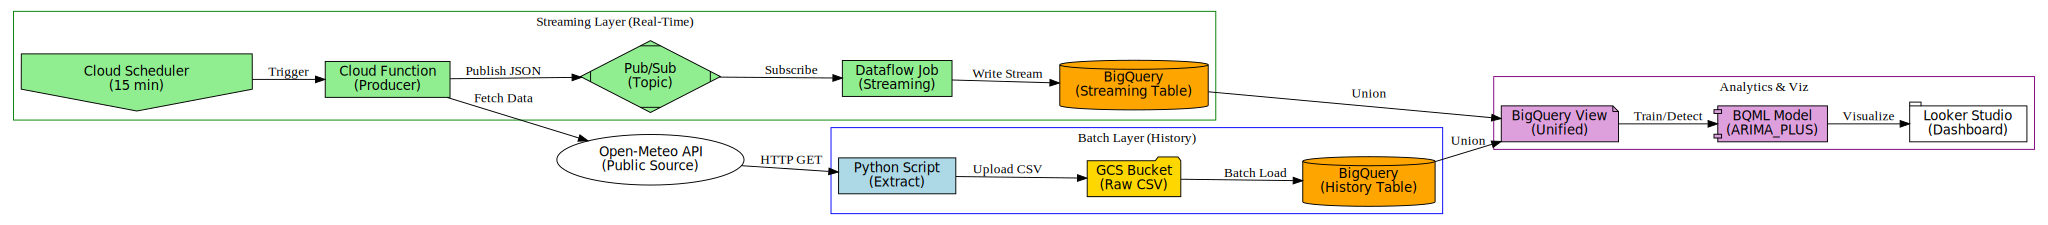

In [2]:
# --- RUN THIS CELL TO GENERATE YOUR ARCHITECTURE DIAGRAM ---
!apt-get -qq install graphviz > /dev/null
!pip install -q graphviz

from graphviz import Digraph

# Initialize the Diagram
dot = Digraph(comment='Weather Anomaly Pipeline')
dot.attr(rankdir='LR') # Left to Right layout
dot.attr('node', shape='box', style='filled', fillcolor='lightgrey', fontname='Sans')

# --- Define Nodes ---
# External
dot.node('API', 'Open-Meteo API\n(Public Source)', shape='ellipse', fillcolor='white')

# Batch Layer (Top)
with dot.subgraph(name='cluster_batch') as c:
    c.attr(label='Batch Layer (History)', color='blue')
    c.node('Colab', 'Python Script\n(Extract)', fillcolor='lightblue')
    c.node('GCS', 'GCS Bucket\n(Raw CSV)', shape='folder', fillcolor='gold')
    c.node('BQ_Hist', 'BigQuery\n(History Table)', shape='cylinder', fillcolor='orange')

# Streaming Layer (Bottom)
with dot.subgraph(name='cluster_stream') as c:
    c.attr(label='Streaming Layer (Real-Time)', color='green')
    c.node('Sched', 'Cloud Scheduler\n(15 min)', shape='invhouse', fillcolor='lightgreen')
    c.node('Func', 'Cloud Function\n(Producer)', fillcolor='lightgreen')
    c.node('PubSub', 'Pub/Sub\n(Topic)', shape='Mdiamond', fillcolor='lightgreen')
    c.node('Dataflow', 'Dataflow Job\n(Streaming)', fillcolor='lightgreen')
    c.node('BQ_Stream', 'BigQuery\n(Streaming Table)', shape='cylinder', fillcolor='orange')

# Analytics Layer (Right)
with dot.subgraph(name='cluster_analytics') as c:
    c.attr(label='Analytics & Viz', color='purple')
    c.node('View', 'BigQuery View\n(Unified)', shape='note', fillcolor='plum')
    c.node('ML', 'BQML Model\n(ARIMA_PLUS)', shape='component', fillcolor='plum')
    c.node('Looker', 'Looker Studio\n(Dashboard)', shape='tab', fillcolor='white')

# --- Define Edges ---
# Batch Flow
dot.edge('API', 'Colab', label='HTTP GET')
dot.edge('Colab', 'GCS', label='Upload CSV')
dot.edge('GCS', 'BQ_Hist', label='Batch Load')

# Streaming Flow
dot.edge('Sched', 'Func', label='Trigger')
dot.edge('Func', 'API', label='Fetch Data')
dot.edge('Func', 'PubSub', label='Publish JSON')
dot.edge('PubSub', 'Dataflow', label='Subscribe')
dot.edge('Dataflow', 'BQ_Stream', label='Write Stream')

# Analytics Flow
dot.edge('BQ_Hist', 'View', label='Union')
dot.edge('BQ_Stream', 'View', label='Union')
dot.edge('View', 'ML', label='Train/Detect')
dot.edge('ML', 'Looker', label='Visualize')

# Render
print("Generating Architecture Diagram...")
display(dot)

**Operations & Reproducibility Manual**



---


1. Cost Controls & Efficiency
To ensure this pipeline remains within the Google Cloud Free Tier, the following controls were implemented:

Cloud Scheduler Frequency: Configured to run every 15 minutes (96 invocations/day). This stays well below the Cloud Run Free Tier limit of 2 million invocations per month.

Dataflow Auto-Scaling: The Dataflow job is configured with max_workers=1 and machine_type=e2-small to minimize compute costs during streaming idle times.

BigQuery Partitioning: The weather_history table is partitioned by DAY. This ensures analytic queries only scan relevant dates rather than the entire dataset, reducing bytes scanned.



---



2. Failure Handling Strategy
API Rate Limiting (HTTP 429): The Open-Meteo API is public. If the pipeline encounters a 429 Too Many Requests error:

Graceful Handling: The Cloud Function includes a try/except block to catch HTTP errors. It logs the warning to Cloud Logging but returns a 500 status code to acknowledge the failure without crashing the Dataflow pipeline.

Data Recovery: Since the Dataflow pipeline is decoupled via Pub/Sub, a temporary API failure results in a gap in data, but the pipeline automatically resumes processing as soon as the API becomes available again.


---


3. Security Architecture
No Hardcoded Secrets: By utilizing the Open-Meteo API (Open Data), we eliminated the need for API Keys. This adheres to the "Secure by Design" principle.

IAM Roles:

The Cloud Function runs with a dedicated Service Account.

Pub/Sub relies on strict Pub/Sub Publisher and Pub/Sub Subscriber roles, ensuring least-privilege access.


---


4. Reproducibility: Spin Up / Spin Down
How to Spin Up the Pipeline

Run Phase 1 (Batch): Execute the "Phase 1" cell in this notebook. This will automatically create the GCS Bucket, BigQuery Dataset, and load the historical data.

Deploy Streaming:

Create Pub/Sub Topic: weather-live-topic.

Deploy Cloud Function fetch-weather (Source provided in Phase 2).

Create Cloud Scheduler weather-poller (Frequency: */15 * * * *).

Start Dataflow: Launch a job from the "Pub/Sub to BigQuery" template pointing to the weather-live-topic subscription.

Verify: Run the "Pipeline Validator" cell to confirm new rows are arriving.